In [1]:
from numpy.random import seed
seed(42)
from tensorflow.keras.utils import set_random_seed
set_random_seed(42)

2023-12-01 16:20:02.132887: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-01 16:20:02.443329: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-01 16:20:02.443358: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-01 16:20:02.445066: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-01 16:20:02.585437: I tensorflow/core/platform/cpu_feature_g

In [3]:
from utils import load_data, vis_data, general_preprocessing, get_dataset, get_results, plot_maps, normalize_image, draw_saliency, draw_CAM

import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.utils import load_img
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf
import os
import json

In [4]:
# Indicar que no se ha de tener en cuenta ninguna GPU, así el modelo se ejecutará en la CPU
tf.config.set_visible_devices([], 'GPU')

2023-11-25 08:49:45.395550: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-11-25 08:49:45.395569: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: b3415224f31e
2023-11-25 08:49:45.395573: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: b3415224f31e
2023-11-25 08:49:45.395627: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: 545.23.6
2023-11-25 08:49:45.395636: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: 545.23.6
2023-11-25 08:49:45.395640: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:309] kernel version seems to match DSO: 545.23.6


In [5]:
#Se crea una lista para cada clase de imágenes y se guardan en cada una los paths correspondientes
lung_aca, lung_n, lung_scc = load_data()

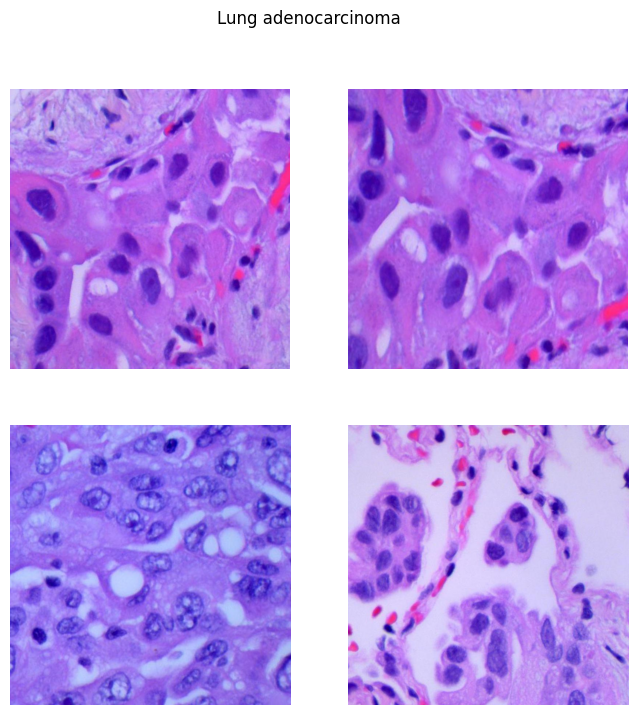

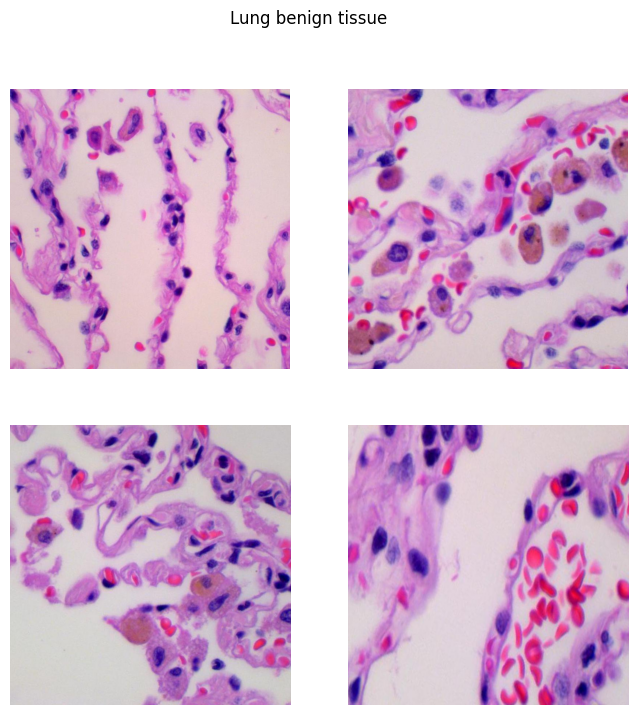

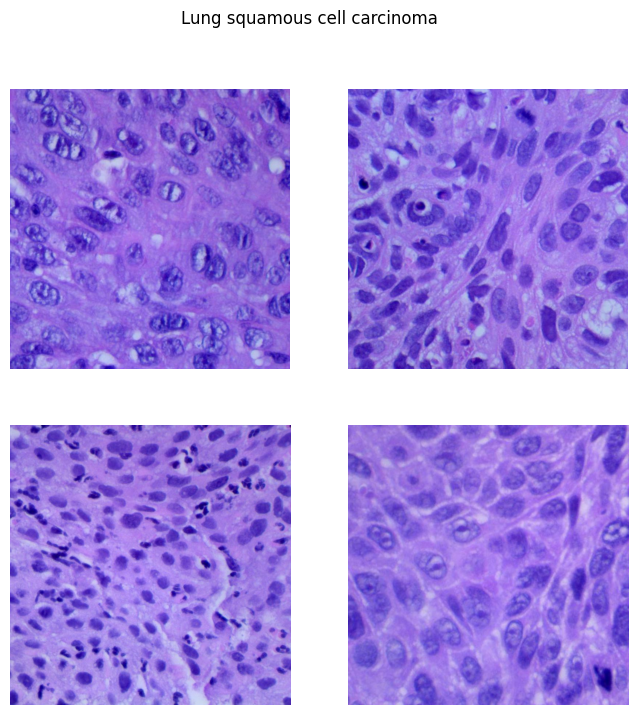

In [6]:
#Se previsualizan las imágenes.
vis_data(lung_aca, lung_n, lung_scc)

In [7]:
def preprocessing_ResNet(image_path, label):

    image, label = general_preprocessing(image_path, label)

    image = tf.keras.applications.resnet.preprocess_input(image)
    #This allows input to have the same format as the images used for training the ResNEt 101 net

    return image, label

In [8]:
train_dataset, val_dataset, test_dataset = get_dataset(preprocessing_ResNet, lung_aca, lung_n, lung_scc)

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
#Se carga la red neuronal con la que queramos hacer el Transfer Learning:

In [9]:
ResNet50 = tf.keras.applications.resnet.ResNet50(input_shape = (350,350,3),
                                               include_top=False,
                                               weights='imagenet')

In [5]:
ResNet50.trainable = False #Ponemos las capas como NO entrenables
ResNet50.summary()

In [ ]:
# Se crean las capas que se quieren añadir al modelo InceptionV3:

In [10]:
output = ResNet50.layers[-2].output

output = tf.keras.layers.Flatten()(output)

output_layer = tf.keras.layers.Dense(512, activation = 'relu')(output)
output_layer = tf.keras.layers.Dense(256, activation = 'relu')(output_layer)
output_layer = tf.keras.layers.Dense(128, activation = 'relu')(output_layer)
output_layer = tf.keras.layers.Dense(32, activation = 'relu')(output_layer)
output_layer = tf.keras.layers.Dense(16, activation = 'relu')(output_layer)
output_layer = tf.keras.layers.Dense(3, activation = 'softmax')(output_layer)

ResNet50 = tf.keras.Model(inputs= ResNet50.input, outputs= output_layer)

In [12]:
ResNet50.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 350, 350, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 356, 356, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 175, 175, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 175, 175, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

In [ ]:
#En las siguientes celdas se definen los callbacks a usar

In [11]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

In [12]:
def scheduler(epoch, lr):
  if epoch < 20:
    return lr
  else:
    return lr * tf.math.exp(-0.1)

learning_rate_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [13]:
checkpoint_filepath = '../ModelCheckpoints/Comprovacio_ResNet.h5'

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [14]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    mode='max',
    restore_best_weights=True,
    start_from_epoch=0)

In [48]:
ResNet50.compile(loss='categorical_crossentropy', optimizer= optimizer, metrics = ['accuracy'])

In [49]:
history = ResNet50.fit(
    train_dataset,
    epochs=100, 
    batch_size=32, 
    validation_data = val_dataset, 
    callbacks = [learning_rate_scheduler, model_checkpoint_callback, early_stop])

Epoch 1/100
375/375 [==============================] - 521s 1s/step - loss: 0.6063 - accuracy: 0.9189 - val_loss: 0.8198 - val_accuracy: 0.8853 - lr: 1.0000e-04
Epoch 2/100
375/375 [==============================] - 529s 1s/step - loss: 0.1819 - accuracy: 0.9647 - val_loss: 0.1260 - val_accuracy: 0.9727 - lr: 1.0000e-04
Epoch 3/100
375/375 [==============================] - 528s 1s/step - loss: 0.1571 - accuracy: 0.9685 - val_loss: 0.0809 - val_accuracy: 0.9847 - lr: 1.0000e-04
Epoch 4/100
375/375 [==============================] - 535s 1s/step - loss: 0.1657 - accuracy: 0.9746 - val_loss: 0.0871 - val_accuracy: 0.9833 - lr: 1.0000e-04
Epoch 5/100
375/375 [==============================] - 538s 1s/step - loss: 0.2822 - accuracy: 0.9628 - val_loss: 0.1587 - val_accuracy: 0.9753 - lr: 1.0000e-04
Epoch 6/100
375/375 [==============================] - 535s 1s/step - loss: 0.0779 - accuracy: 0.9862 - val_loss: 0.1689 - val_accuracy: 0.9700 - lr: 1.0000e-04
Epoch 7/100
375/375 [=============

**Fine tuning** 

In [15]:
ResNet50.load_weights(checkpoint_filepath)

In [11]:
ResNet50.trainable = True

In [17]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)

In [12]:
checkpoint_filepath2 = '../ModelCheckpoints/Comprovacio_ResNet_Fine.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath2,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [19]:
ResNet50.compile(loss='categorical_crossentropy', optimizer= optimizer, metrics = ['accuracy'])

In [20]:
history = ResNet50.fit(
    train_dataset, 
    epochs=100, 
    batch_size=32, 
    validation_data = val_dataset, 
    callbacks = [learning_rate_scheduler, model_checkpoint_callback, early_stop])

Epoch 1/100


2023-11-07 06:09:58.826292: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fbde00d78f0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2023-11-07 06:09:58.826358: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2023-11-07 06:09:58.860702: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-07 06:09:58.984091: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2023-11-07 06:09:58.985523: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-07 06:09:58.988619: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-07 06:09:58.98870

  1/375 [..............................] - ETA: 1:32:29 - loss: 0.5461 - accuracy: 0.7500

2023-11-07 06:10:03.077937: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.


  2/375 [..............................] - ETA: 23:49 - loss: 1.0990 - accuracy: 0.7188  

2023-11-07 06:10:06.908334: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.


 97/375 [======>.......................] - ETA: 18:15 - loss: 0.3941 - accuracy: 0.9172

2023-11-07 06:16:21.268024: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.


375/375 [==============================] - 1479s 4s/step - loss: 0.1641 - accuracy: 0.9607 - val_loss: 0.0179 - val_accuracy: 0.9920 - lr: 1.0000e-05
Epoch 2/100
375/375 [==============================] - 1446s 4s/step - loss: 0.0039 - accuracy: 0.9989 - val_loss: 0.0135 - val_accuracy: 0.9947 - lr: 1.0000e-05
Epoch 3/100
375/375 [==============================] - 1484s 4s/step - loss: 5.5570e-04 - accuracy: 1.0000 - val_loss: 0.0141 - val_accuracy: 0.9940 - lr: 1.0000e-05
Epoch 4/100
375/375 [==============================] - 1442s 4s/step - loss: 1.7849e-04 - accuracy: 1.0000 - val_loss: 0.0130 - val_accuracy: 0.9940 - lr: 1.0000e-05
Epoch 5/100
375/375 [==============================] - 1473s 4s/step - loss: 1.0487e-04 - accuracy: 1.0000 - val_loss: 0.0123 - val_accuracy: 0.9947 - lr: 1.0000e-05
Epoch 6/100
375/375 [==============================] - 1504s 4s/step - loss: 7.5001e-05 - accuracy: 1.0000 - val_loss: 0.0119 - val_accuracy: 0.9947 - lr: 1.0000e-05
Epoch 7/100
375/375 [===

2023-11-07 09:35:42.426197: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.


375/375 [==============================] - 1518s 4s/step - loss: 3.2717e-05 - accuracy: 1.0000 - val_loss: 0.0117 - val_accuracy: 0.9947 - lr: 1.0000e-05
Epoch 10/100
375/375 [==============================] - 1477s 4s/step - loss: 2.5072e-05 - accuracy: 1.0000 - val_loss: 0.0117 - val_accuracy: 0.9953 - lr: 1.0000e-05
Epoch 11/100
375/375 [==============================] - 1460s 4s/step - loss: 1.9416e-05 - accuracy: 1.0000 - val_loss: 0.0116 - val_accuracy: 0.9947 - lr: 1.0000e-05
Epoch 12/100
375/375 [==============================] - 1546s 4s/step - loss: 1.5248e-05 - accuracy: 1.0000 - val_loss: 0.0115 - val_accuracy: 0.9947 - lr: 1.0000e-05
Epoch 13/100
375/375 [==============================] - 1499s 4s/step - loss: 1.2190e-05 - accuracy: 1.0000 - val_loss: 0.0114 - val_accuracy: 0.9947 - lr: 1.0000e-05
Epoch 14/100
375/375 [==============================] - 1515s 4s/step - loss: 9.8668e-06 - accuracy: 1.0000 - val_loss: 0.0114 - val_accuracy: 0.9947 - lr: 1.0000e-05
Epoch 15/10

In [13]:
ResNet50.load_weights(checkpoint_filepath2)

In [14]:
y_pred_ResNet50 = ResNet50.predict(test_dataset)

47/47 [==============================] - 53s 1s/step


In [15]:
#Se guardan las predicciones en un fichero json, por si se quisieran acceder sin cargar el modelo.
with open('predResNet50', 'w') as file:
    json.dump(y_pred_ResNet50.tolist(), file)

In [16]:
results_ResNet50 = get_results(test_dataset, y_pred_ResNet50)
print(results_ResNet50)

              precision    recall  f1-score   support

           0       0.99      0.98      0.99       500
           1       1.00      1.00      1.00       500
           2       0.98      0.99      0.99       500

   micro avg       0.99      0.99      0.99      1500
   macro avg       0.99      0.99      0.99      1500
weighted avg       0.99      0.99      0.99      1500
 samples avg       0.99      0.99      0.99      1500



In [ ]:
#Visualicación para evaluar la explicabilidad del modelo:

In [7]:
#Se generantres números aleatorios para decidir qué imagenes usar para crear los Saliency Maps y Class Activation Maps.
#Al generarse los números aleatorios a partir de la misma semilla, serán los mismos en todas las notebooks.

aca_random = random.randint(1, 5000)
n_random = random.randint(1, 5000)
scc_random = random.randint(1, 5000)

In [8]:
aca_random, n_random, scc_random

(913, 205, 2254)

In [9]:
#Se generan los paths correspondientes a las imágenes seleccionadas aleatoriamente.

aca_path = '../lung_image_sets/lung_aca/lungaca' + str(aca_random) +'.jpeg'
n_path = '../lung_image_sets/lung_n/lungn' + str(n_random) +'.jpeg'
scc_path = '../lung_image_sets/lung_scc/lungscc' + str(scc_random) +'.jpeg'

In [10]:
#Se crea una lista con los paths en cuestión

selected_images = [aca_path, n_path, scc_path]

#### Saliency Map

In [11]:
# Se crea una lista con los paths en los que guardar los Saliency Maps de esta red neuronal para cada una de las imágenes seleccionadas.
saliency_paths = ['./SalMaps/aca_ResNet50.jpg', './SalMaps/n_ResNet50.jpg', './SalMaps/scc_ResNet50.jpg']

2023-11-19 07:42:05.182915: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8905
2023-11-19 07:42:05.224004: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-11-19 07:42:05.376001: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


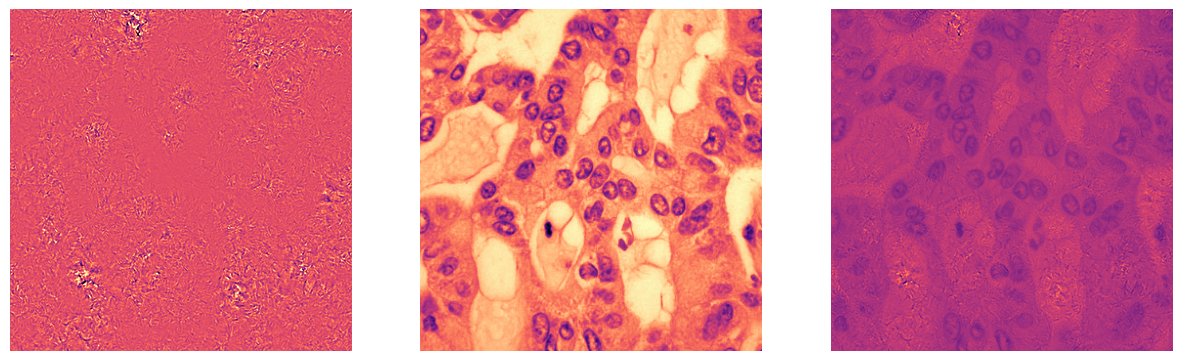

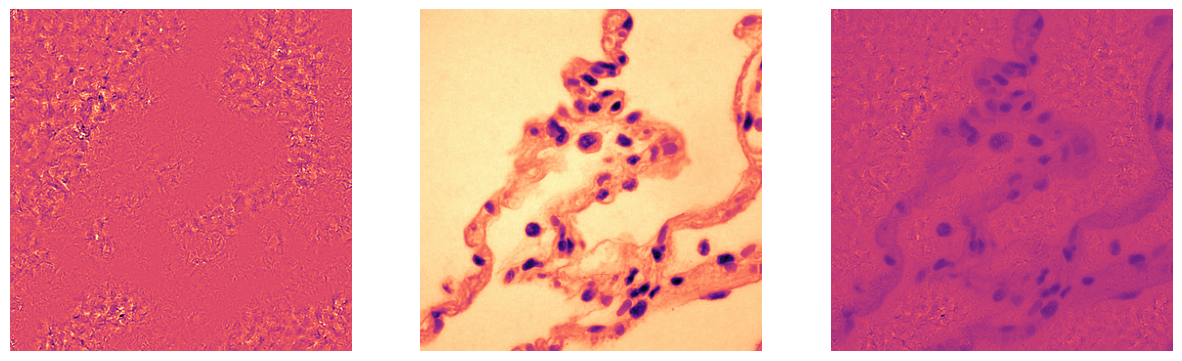

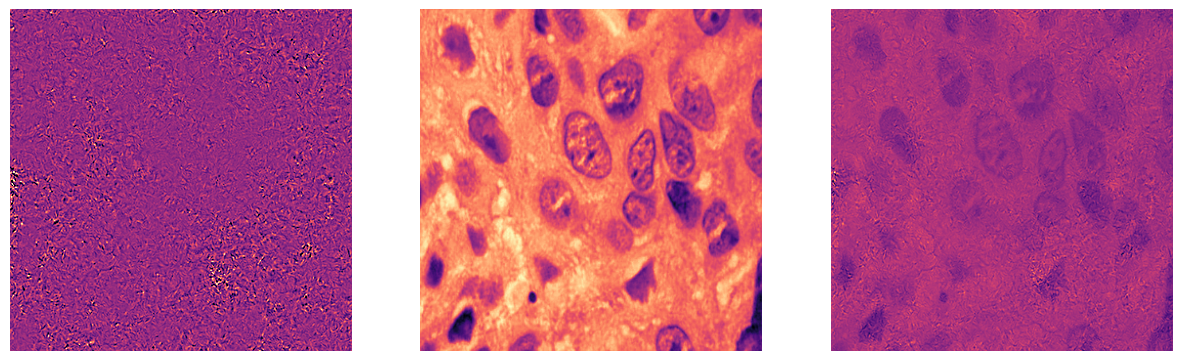

In [12]:
# Se generan los Saliency Maps, se muestran por pantalla y se guardan en los paths correspondientes.
for i in range(len(selected_images)):
    draw_saliency(selected_images[i], ResNet50, preprocessing_ResNet, saliency_paths[i])

#### Class Activation Map

In [13]:
#Se declaran variables necesarias para draw_CAM
img_size = (350, 350)
alpha = 1

In [15]:
# Se crea una lista con los paths en los que guardar los Class Activation Maps de esta red neuronal para cada una de las imágenes seleccionadas.
cam_paths = ['./CamMaps/aca_ResNet50.jpg', './CamMaps/n_ResNet50.jpg', './CamMaps/scc_ResNet50.jpg']

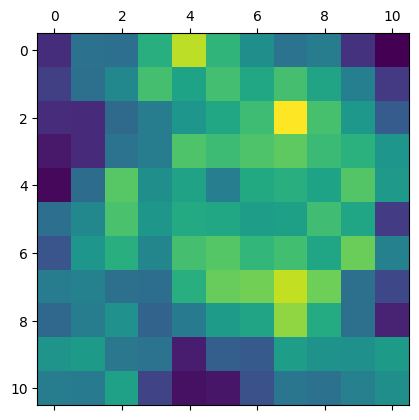

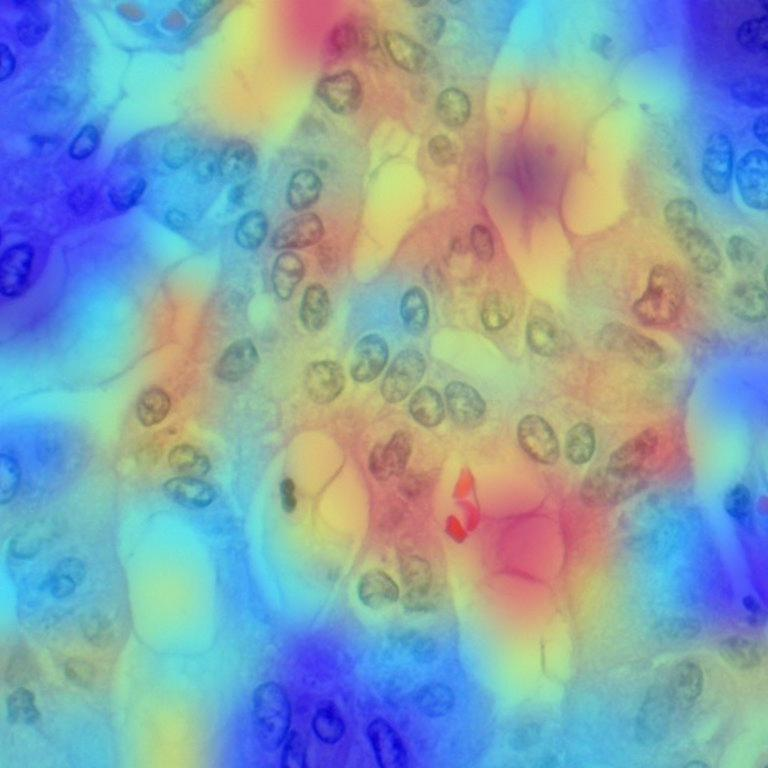

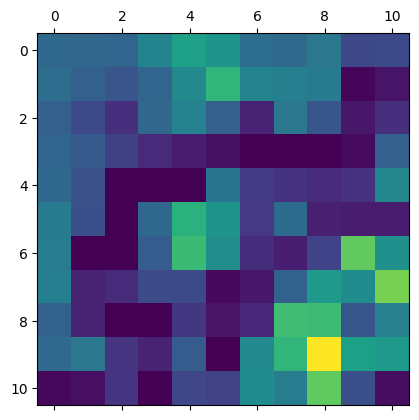

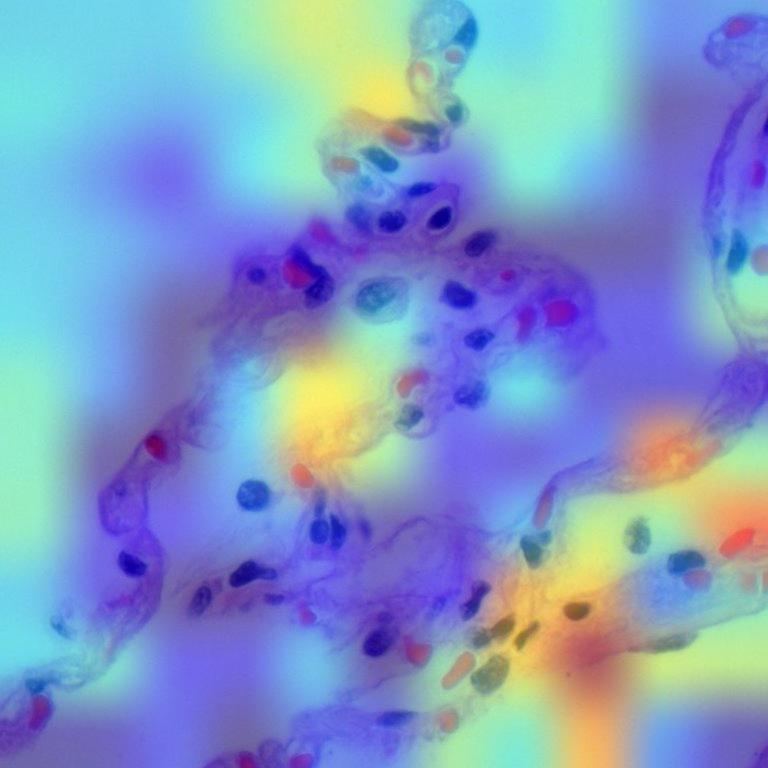

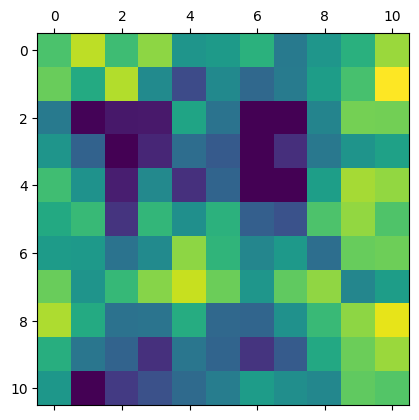

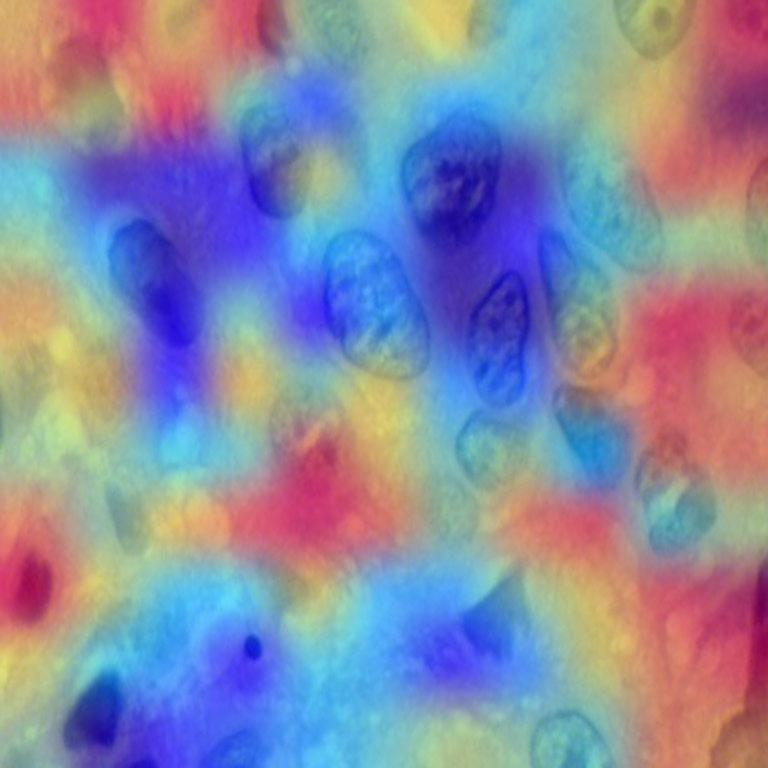

In [16]:
# Se generan los Class Activation Maps, se muestran por pantalla y se guardan en los paths correspondientes.
for i in range(len(selected_images)):
    draw_CAM(selected_images[i], img_size, ResNet50, 'resnet', cam_paths[i], alpha, preprocessing_ResNet, pred_index = None)